<a href="https://colab.research.google.com/github/davidcechak/Grasp-and-lift-EEG-detection/blob/master/UI%20Project%20CNN%20develop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from google.colab import drive
drive.mount('/content/drive')
# authorization code
# 4/1QFvlXzVAHaB1JcaL1XcIYfxSAUFNTDrGYhmWhLPszB_YYLBVo70Jew

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import math
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.patches as mpatches

import gc
from enum import Enum


In [66]:
# import zipfile
# with zipfile.ZipFile("../input/grasp-and-lift-eeg-detection/train.zip","r") as zip_ref:
#     zip_ref.extractall("../input/train/")

In [67]:
# kaggle-style loading
# train_set_signals = pd.read_csv("../input/graspandlift/train/train/subj1_series1_data.csv")
# train_set_signals.head()

# **Load data**

In [68]:
GRASP_AND_LIFT_PATH = "/content/drive/My Drive/grasp-and-lift-eeg-detection"

In [69]:
train_set_signals = pd.read_csv(GRASP_AND_LIFT_PATH + "/train/subj1_series1_data.csv")
train_set_signals.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


In [70]:
eeg_channels = train_set_signals.columns.drop('id')

In [71]:
train_set_labels = pd.read_csv(GRASP_AND_LIFT_PATH + "/train/subj1_series1_events.csv")
train_set_labels.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


In [72]:
labels = train_set_labels.columns.drop('id')
print(labels)

Index(['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased'],
      dtype='object')


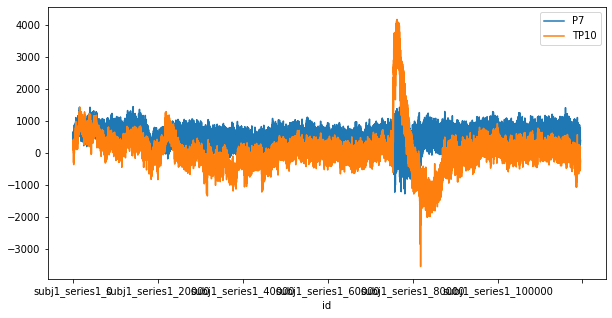

In [73]:
axis = plt.gca()
downSampleToShow = 1
train_set_signals[::downSampleToShow].plot(x="id", y="P7", ax=axis)
train_set_signals[::downSampleToShow].plot(x="id", y="TP10", ax=axis, figsize=(10,5))
plt.show()

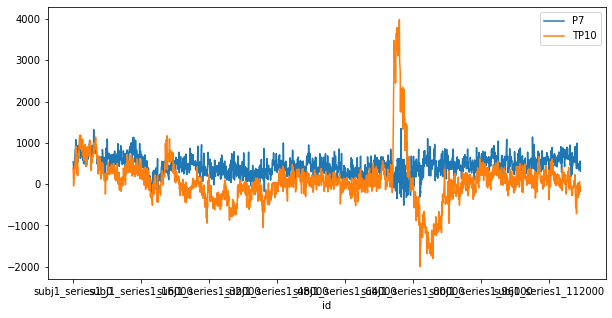

In [74]:
axis = plt.gca()
downSampleToShow = 64
train_set_signals[::downSampleToShow].plot(x="id", y="P7", ax=axis)
train_set_signals[::downSampleToShow].plot(x="id", y="TP10", ax=axis, figsize=(10,5))
plt.show()

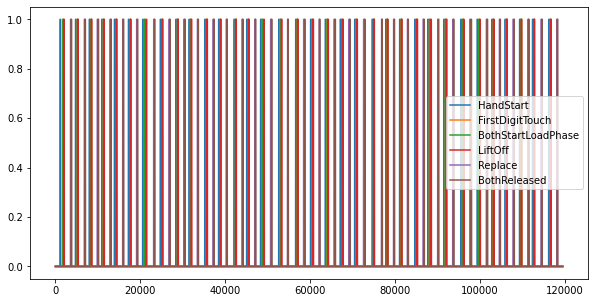

In [75]:
train_set_labels.plot(figsize=(10,5))
plt.show()

In [76]:
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))
train_set_complete.head()

,order,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704,subj1_series1_0,0,0,0,0,0,0
1,1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737,subj1_series1_1,0,0,0,0,0,0
2,2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677,subj1_series1_2,0,0,0,0,0,0
3,3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592,subj1_series1_3,0,0,0,0,0,0
4,4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581,subj1_series1_4,0,0,0,0,0,0


In [77]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        i+=1

HandStart = red
FirstDigitTouch = blue
BothStartLoadPhase = yellow
LiftOff = green
Replace = purple
BothReleased = black


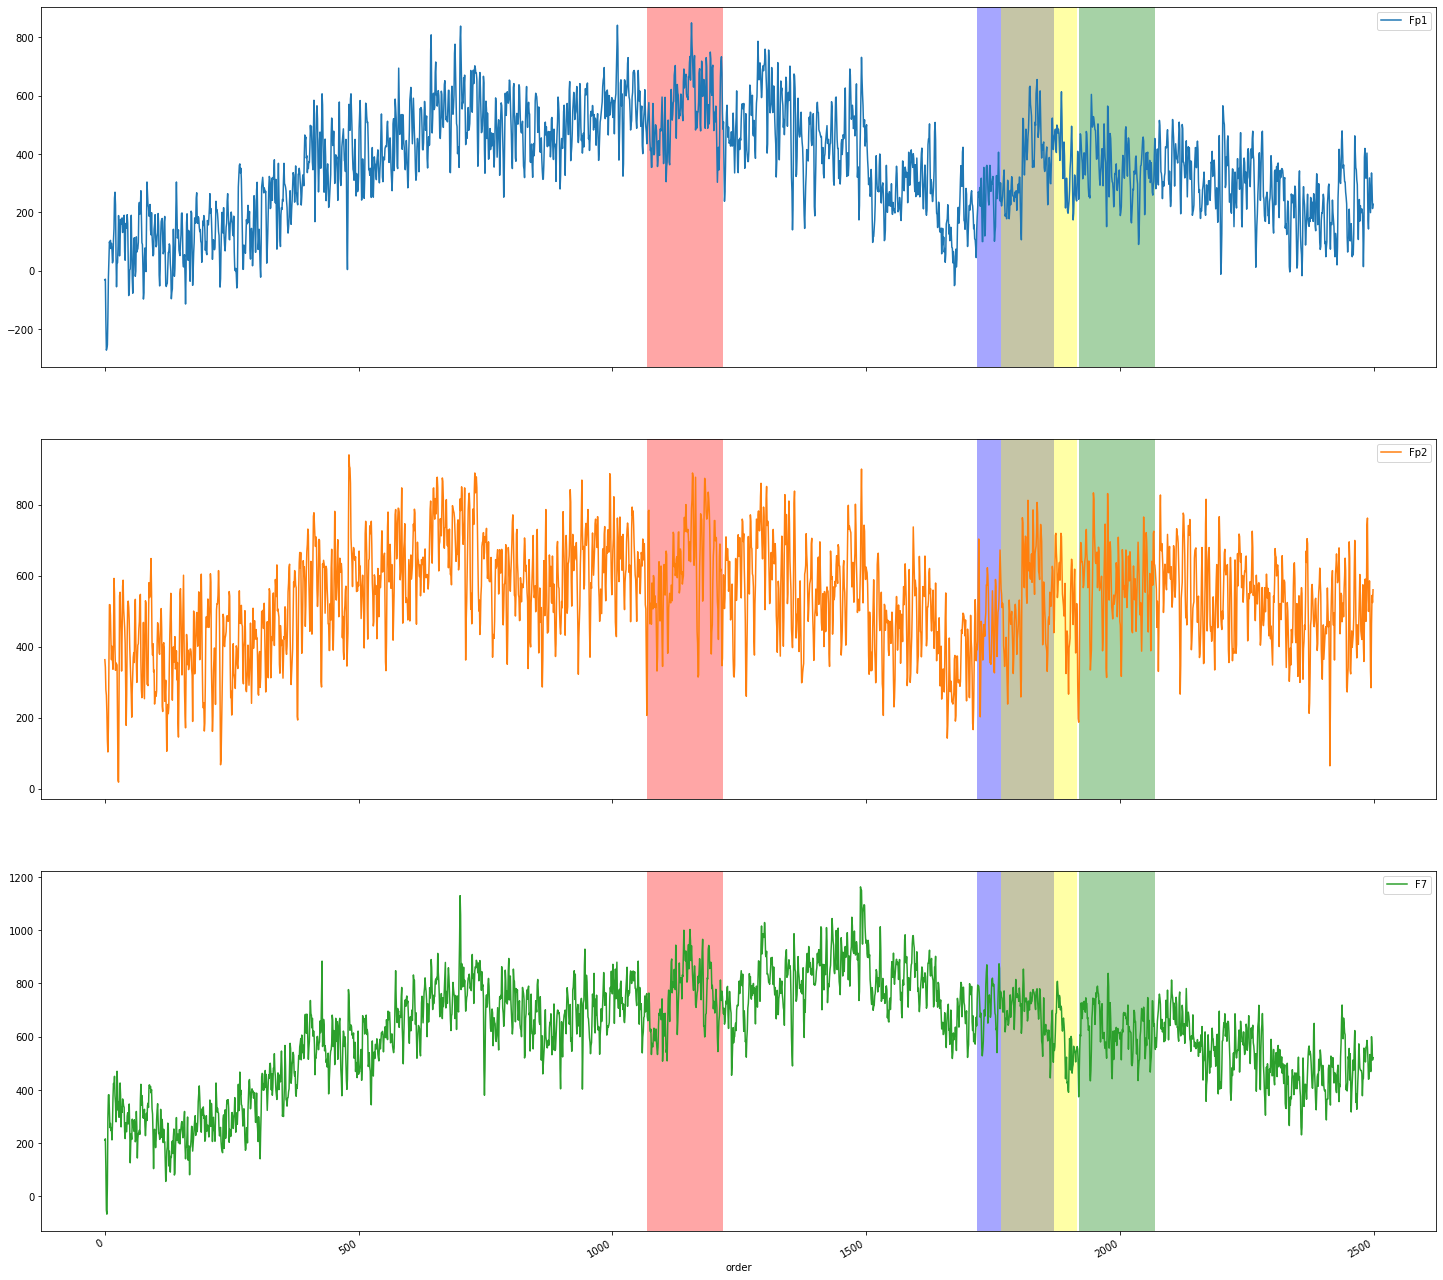

In [78]:
secondsToShow = 5
channelsToShow = 3
labelsToShow = 6

sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","blue","yellow","green", "purple", "black"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(25,25))
for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1
plt.show()

# **Loading and preparation methods**

In [79]:
def load_train_data(subject, series):
    train_set_signals = pd.read_csv(GRASP_AND_LIFT_PATH + f"/train/subj{subject}_series{series}_data.csv")
    train_set_labels = pd.read_csv(GRASP_AND_LIFT_PATH + f"/train/subj{subject}_series{series}_events.csv")
    return train_set_signals, train_set_labels
   

def prepare_labels(data):    
    return data.drop("id", axis=1)
    

# used
# Standardize data by removing the mean and scaling to unit variance
def prepare_signals(data):
    data = data.drop("id", axis=1)
    columns = data.columns    
    scaler = StandardScaler() 
    data = np.asarray(data.astype(float))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=columns)   
    return data


#def convert_np_array_to_pandas(data, columns):
#    data = pd.DataFrame(data, columns=columns)
#    return data
    

def load_train_data_prepared(subject, series):    
    signals, labels = load_train_data(subject,series)    
    return prepare_signals(signals), prepare_labels(labels)   


# def split_data(data_to_split, percent):
#     percenttotrainon = percent
#     spliton = math.floor(float(len(data_to_split))*(percenttotrainon/float(100)))
#     return data_to_split.iloc[:spliton], data_to_split[spliton:]   


def load_mass_data_2D(fromsubj = 1, tosubj = 12, fromSerie = 1, toSerie = 8, look_back = 1, downsample = 1): 
    # default downsample = 1 means no downsampling
    signals_dfs=[]
    labels_dfs=[]
    for j in range(fromsubj, tosubj+1): #we have 12 subjects
        for i in range(fromSerie, toSerie+1): #we have 8 series availible for each subject
            signals, labels = load_train_data_prepared(subject=j, series=i)
            signals_dfs.append(signals)
            labels_dfs.append(labels)        

    signals_complete=pd.concat(signals_dfs)
    labels_complete=pd.concat(labels_dfs)
    
    signalsDownsampled, labelsDownsampled = create_dataset(signals_complete.values[::downsample], labels_complete.values[::downsample], look_back)
    return signalsDownsampled, labelsDownsampled


# def load_mass_data_1D(fromsubj = 1, tosubj = 12, fromSerie = 1, toSerie = 8, downsample = 1): 
#     # default downsample = 1 means no downsampling
#     signals_dfs=[]
#     labels_dfs=[]
#     for j in range(fromsubj, tosubj+1): #we have 12 subjects
#         for i in range(fromSerie, toSerie+1): #we have 8 series availible for each subject
#             signals, labels = load_train_data_prepared(subject=j, series=i)
#             signals_dfs.append(signals)
#             labels_dfs.append(labels)        

#     signals_complete=pd.concat(signals_dfs)
#     labels_complete=pd.concat(labels_dfs)
    
#     dataX, dataY = signals_complete.values[::downsample], labels_complete.values[::downsample]
#     return dataX, dataY


def load_labels_header(): 
    signals, labels = load_train_data_prepared(1,1)
    return labels.columns

# used
# Loads all test series for one subject
# Returns test dataset, signal headers, ids
# look back: x previous rows to be assign to every data row
# serie: correct numbers for test-submit series are 9 and 10
def load_test_data_2D(subject, look_back, downsampling, serie):
    if(serie < 9 or 10 < serie):
        print(" *** Test series for sumbmission are only 9 and 10 *** ")
    signals_dfs=[]               
    signals = pd.read_csv(GRASP_AND_LIFT_PATH + f"/test/subj{subject}_series{serie}_data.csv")

    signals_dfs.append(signals)
    signals_data = pd.concat(signals_dfs)
    ids = signals_data["id"]
    signals_data = prepare_signals(signals_data)
    dataX = create_test_dataset(signals_data.values[::downsampling], look_back)
    return dataX, signals_data.columns, ids


def create_dataset(dataset, labels, look_back=1):
    dataX = []
    dataY = labels[look_back:]
    
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), ])
    
    return np.array(dataX), np.array(dataY)


# used
# To every data row assigns previous x rows (look back)
def create_test_dataset(dataset, look_back=1):
    dataX = []
    
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), ])
    
    return np.array(dataX)


# func load_mass_data_2D(..) can be used for the same purpose
# def load_mass_data_subject(subject, fromseries, toseries): #we have 12 subjects
#     signals_dfs=[]
#     labels_dfs=[]
#     for i in range(fromseries,toseries+1): #we have 8 series availible for each subject        
#         signals, labels = load_train_data_prepared(subject, series=i)
#         signals_dfs.append(signals)
#         labels_dfs.append(labels)        

#     signals_complete=pd.concat(signals_dfs)
#     labels_complete=pd.concat(labels_dfs)
#     return signals_complete, labels_complete 


## scaleOnes(..)

In [80]:
def scaleOnes(signals, labels, neighborhood_length):
    appendSignals = []
    appendLabels = []
    sequence_of_ones_indexes = [] # sekvence jednicek co byly za sebou (jejich indexuu)
    list_of_sequences_of_ones_indexes = [] # list takovych sekvencii
    was_previous_label_one = False 
    # number of sequences of ones or zeroes
    number_of_zeros = 0
    number_of_ones = 0
    
    for j in range(0, len(signals)):
        if(1 in labels[j]):
            if(not was_previous_label_one):
                if(len(sequence_of_ones_indexes) != 0):
                    list_of_sequences_of_ones_indexes.append(sequence_of_ones_indexes)
                sequence_of_ones_indexes = []
                sequence_of_ones_indexes.append(j)
            if(was_previous_label_one):
                sequence_of_ones_indexes.append(j)
            was_previous_label_one = True
            number_of_ones = number_of_ones + 1
        else:
            was_previous_label_one = False
            number_of_zeros = number_of_zeros + 1
    list_of_sequences_of_ones_indexes.append(sequence_of_ones_indexes)
    
    scale_constant = 1
    scale = int((number_of_zeros // number_of_ones) * scale_constant) + 1
    print("scale: ", scale)
    for s in range(0, scale):
        for sequence in list_of_sequences_of_ones_indexes:
            #pridavam okoli pred jednickama               
            j = sequence[0]
            k = sequence[-1]
            for i in range(0, neighborhood_length):
                appendSignals.append(signals[j - (neighborhood_length - i)])
                appendLabels.append(labels[j - (neighborhood_length - i)])

            for i in sequence:
                appendSignals.append(signals[i])
                appendLabels.append(labels[i])

            #pridavam okoli za jednickama
            if(len(signals) > k + neighborhood_length):
                for i in range(0, neighborhood_length):
                    appendSignals.append(signals[k + i])
                    appendLabels.append(labels[k + i])

    signalsToAppend = np.array(appendSignals)
    labelsToAppend = np.array(appendLabels)

    signals = np.concatenate([signals, signalsToAppend])
    labels = np.concatenate([labels, labelsToAppend])
    return signals, labels

## validate and round

In [81]:
def rd(x):
    if(x > 0.1):
        return 1
    return 0

def rd_basic(x):
    return round(x)

def validate(predictions, expected):
    # whole vector predicted correctly 
    succesfullyPredictedVector = 0
    #ones across all expected labels 
    totalOnes = 0
    #zeros across all expected labels 
    totalZeros = 0
    #ones correctly predicted across all labels
    succesfullyPredictedOnes = 0
    #zeros correctly predicted across all labels
    succesfullyPredictedZeros = 0
    #ones expected, but not predicted - across all labels
    notPredictedOnes = 0
    totallyPredictedOnes = 0
#    onesPredictedSucc = 0
    
    # counts labels from expected data
    vectors_with_at_least_one = 0
    # counts labels from expected data
    multiple_ones_vectors = 0 

    for i in range(0, len(expected)): 
        predicted_vector = list(map(rd, predictions[i]))
        if(np.array_equal(predicted_vector,expected[i])):
            succesfullyPredictedVector+=1

        if 1 in expected[i]:
            vectors_with_at_least_one += 1
            ones_in_vector = 0
            #print("expected", expected[i], "predicted", predicted_vector)
            
            for j in range(0, len(expected[i])):
                if(expected[i][j] == 1):
                    totalOnes += 1
                    ones_in_vector +=1
                    if (predicted_vector[j] == expected[i][j]):
                        succesfullyPredictedOnes +=1
                    elif (expected[i][j] == 1):
                        notPredictedOnes +=1
                        
                else:
                    totalZeros += 1
                    if (predicted_vector[j] == expected[i][j]):
                        succesfullyPredictedZeros +=1
                        
            if(ones_in_vector > 1):
                multiple_ones_vectors += 1

        for k in range(0, len(predicted_vector)):
            if (predicted_vector[k] == 1):
                totallyPredictedOnes += 1  
                
    # Addition of +0.00001 to avoid division by zero
    print("total acc on vectors: ", succesfullyPredictedVector/(len(predictions)+0.00001))
    print("total acc on ones and zeros: ", (succesfullyPredictedOnes+succesfullyPredictedZeros)/(totalOnes+totalZeros))
    print("1s predicted correctly: ", succesfullyPredictedOnes, "/",totalOnes, " = ", succesfullyPredictedOnes/(totalOnes+0.00001))
    print("0s predicted correctly: ", succesfullyPredictedZeros, "/",totalZeros, " = ", succesfullyPredictedZeros/(totalZeros))
#    print("ones predicted but not expected (out of total ones): ", totallyPredictedOnes - onesPredictedSucc, "/", totalOnes)
#    print("1s predicted but not expected (in comparison with correctly predicted): ", totallyPredictedOnes - succesfullyPredictedOnes , "/", succesfullyPredictedOnes, " = ", (totallyPredictedOnes - succesfullyPredictedOnes)/(succesfullyPredictedOnes+0.00001))
    print("false positive ratio (false positives/actual negative events): ", totallyPredictedOnes - succesfullyPredictedOnes , "/", (len(expected)*6-totalOnes), " = ", (totallyPredictedOnes - succesfullyPredictedOnes)/((len(expected)*6-totalOnes)+0.00001))
#    false positive rate is calculated as the ratio between the number of negative events wrongly categorized as positive (false positives) and the total number of actual negative events 
    print("vectors with multiple 1s: ", multiple_ones_vectors)
    print("total vectors with 1s: ", vectors_with_at_least_one)
    print("total vectors: ", len(expected))

## validate_labels_separately(..)

In [82]:
def validate_labels_separately(predictions, expected):
    # true positive = predicted 1 expected 1 
    # true negative = predicted 0 expected 0 
    # false positive = predicted 1 expected 0 
    # false negative = predicted 0 expected 1 
    
    oneTruePositive = [0, 0, 0, 0, 0, 0]
    zeroTrueNegative = [0, 0, 0, 0, 0, 0]
    oneFalsePositive = [0, 0, 0, 0, 0, 0]
    zeroFalseNegative = [0, 0, 0, 0, 0, 0]
    onesExpected = [0, 0, 0, 0, 0, 0]
    
    for i in range(0, len(expected)): 
        predictionVec = np.array([rd(xi) for xi in predictions[i]])
        for label in range(6):
            if(predictionVec[label] == rd(expected[i, label])):
                if(predictionVec[label] == 1):
                    oneTruePositive[label] += 1
                if(predictionVec[label] == 0):
                    zeroTrueNegative[label] += 1
            else:
                if(predictionVec[label] == 1):
                    oneFalsePositive[label] += 1
                if(predictionVec[label] == 0):
                    zeroFalseNegative[label] += 1
            if(expected[i][label] == 1):
                onesExpected[label] += 1
            
    # Addition of +0.00001 to avoid division by zero
    for label in range(6):
        print("             ")
        print("label ", label)
        print("total acc: ", (oneTruePositive[label] + zeroTrueNegative[label])/(len(predictions)))
        print("true positive = predicted 1 expected 1: ", oneTruePositive[label], " / ", (onesExpected[label]), " = ", oneTruePositive[label]/(onesExpected[label]), "(out of ones)")
        print("true negative = predicted 0 expected 0: ", zeroTrueNegative[label], "/", (len(predictions)-onesExpected[label]), " = ", zeroTrueNegative[label]/(len(predictions)), "(out of zeros)")
        print("false positive = predicted 1 expected 0: ", oneFalsePositive[label], "/", (len(predictions)), " = ", oneFalsePositive[label]/(len(predictions)))
        print("false negative = predicted 0 expected 1: ", zeroFalseNegative[label], "/", (len(predictions)), " = ", zeroFalseNegative[label]/(len(predictions)))
    print("             ")
    print("Total summary")
    print("total acc: ", (np.sum(oneTruePositive) + np.sum(zeroTrueNegative))/(len(predictions)*6))
    print("true positive = predicted 1 expected 1: ", np.sum(oneTruePositive)/(np.sum(onesExpected)))
    print("true negative = predicted 0 expected 0: ", np.sum(zeroTrueNegative)/(len(predictions)*6-np.sum(onesExpected)))
    print("false positive = predicted 1 expected 0: ", np.sum(oneFalsePositive)/(len(predictions)*6))
    print("false negative = predicted 0 expected 1: ", np.sum(zeroFalseNegative)/(len(predictions)*6))

In [83]:
#https://sccn.ucsd.edu/wiki/Introduction_To_Modern_Brain-Computer_Interface_Design
#https://hal.inria.fr/hal-01055103/file/lotte_EEGSignalProcessing.pdf

# **CNN**

### **Predict**

In [84]:
# Returns np.array, the prediction on given signals
def predict_cnn(test_signals, cnn_list, mode):
    nlenghtTest, nrowsTest, ncolsTest = test_signals.shape
    test_signals_reshaped = test_signals.reshape(nlenghtTest, nrowsTest, ncolsTest, 1)
    if(mode == Mode.single_label_mode):
        for i in range(6):
            result = cnn_list[i].predict(test_signals_reshaped)
            if(i == 0):
                final_result = result
            else:
                print(final_result.shape)
                final_result = np.append(final_result, result, axis = 1)
        return final_result
    elif(mode == Mode.seven_labels):
        for i in range(6):
            result = cnn_list[i].predict(test_signals_reshaped)
            result = np.delete(result, 0, axis = 1)
            if(i == 0):
                final_result = result
            else:
                final_result = np.append(final_result, result, axis = 1)
        return final_result

    else:
        result = cnn_list.predict(test_signals_reshaped)
        return result

## **Highlight and Visualization**

In [85]:
def vizualize_predictions(signals, predictions, expected, labelName, limit=2000): 
    #0-31
    signalIndex = 10
    
    #TODO relevant only for multilabel predictions, else is always 0
    labelIndex = 0
                
    signals = pd.DataFrame(data=np.array(signals))
    axis = signals[signals.columns[signalIndex]].iloc[0:limit].plot(figsize=(20,4))  
        
    expected = pd.DataFrame(data = expected)    
    predictions = pd.DataFrame(data = np.around(predictions))
    
    expectedCropped = expected.iloc[0:limit,]
    predictionsCropped = predictions.iloc[0:limit,]
    
    highlight(expectedCropped[expectedCropped.iloc[:,labelIndex]==1].index, axis, "red")
    highlight(predictionsCropped[predictionsCropped.iloc[:,labelIndex]==1].index, axis, "black")
    
    red_patch = mpatches.Patch(color='red', label='Expected event')
    black_patch = mpatches.Patch(color='black', label='Predicted event')
    plt.legend(handles=[red_patch, black_patch])

    plt.title(labelName)
    plt.show()

## **Upsampling result for submision**

### upsample_result(..)

In [86]:
def upsample_result(results, multiplication_coefficient):
    shape = results.shape
    upsampled_result = np.zeros((shape[0] * multiplication_coefficient, shape[1]))
    for i in range(len(results)):
        for j in range(multiplication_coefficient):
            upsampled_result[i * multiplication_coefficient + j] = results[i]
    return upsampled_result

## **Training**

### train_cnn, cnn_model

In [87]:
# trains CNN with given train data
# Returns void
# trainon_signals: training data
# trainon_labels: labels for training data
# cnn_list: a list of CNN models (if single_label_mode is True), single CNN model (if single_label_mode is False)
# epochs: number of training epochs for each model
# single_label_mode: boolean decides if to train on each label separately or on all of them at once (as a single vector of length 6)
def train_cnn(trainon_signals, trainon_labels, cnn_list, epochs, mode, my_verbose):
    data = trainon_signals
    labels = trainon_labels
    if(my_verbose):
        verbose=1
    else:
        verbose=0
    
    nlenghtData, nrowsData, ncolsData = data.shape
    data_single_label = data.reshape(nlenghtData, nrowsData, ncolsData, 1)
    
    if(mode == Mode.single_label_mode):
        for i in range(6):
            if(my_verbose):
                print("Training model ", i)
            labels_single_label = np.zeros((len(labels), 1))
            for k in range(len(labels)):
                labels_single_label[k][0] = labels[k][i]
                """
                print(labels_single_label[k])
                print(labels_single_label[k][0])
                print("??????")
                labels_single_label[k][1] = labels[k][i]
                print(labels_single_label[k][1])
                for j in range(len(labels_single_label[k][1])):
                    #invert values in second column creating a positive value (1) if there is no event happening
                    labels_single_label[k][1][j] = 1 - labels_single_label[k][1][j]
                """
            cnn_list[i].fit(data_single_label, labels_single_label, epochs=epochs, batch_size=128, verbose=int(my_verbose))          
    elif(mode == Mode.seven_labels):
        for i in range(6):
            if(my_verbose):
                print("Training model ", i)
            labels_single_label = np.zeros((len(labels), 2))
            for k in range(len(labels)):
                labels_single_label[k][0] = labels[k][i]
            cnn_list[i].fit(data_single_label, labels_single_label, epochs=epochs, batch_size=128, verbose=int(my_verbose))
    elif(mode == Mode.standard):
        nlenghtData, nrowsData, ncolsData = data.shape
        data = data.reshape(nlenghtData, nrowsData, ncolsData, 1)
        # in case of single_label_mode == False, cnn_list is not a list but a single model
        cnn_list.fit(data, labels, epochs=epochs, batch_size=128, verbose=int(my_verbose))
        

# look_back: history dimension of every row, number of previous rows appended before every data row
# activation: function for every layer except last one
# last_layer_activation
# loss: function
# output_length: size of the last layer
def cnn_model(look_back, activation, last_layer_activation, loss, output_length, mode):
    cnn = models.Sequential()
    channels = 32
    cnn.add(layers.Conv2D(filters=192, kernel_size=(3,1), activation=activation, input_shape=(look_back, channels, 1)))
    cnn.add(layers.MaxPooling2D((2,1)))
    cnn.add(layers.Dropout(rate=0.3)) 
    cnn.add(layers.Flatten())

    cnn.add(layers.Dense(output_length, activation=last_layer_activation))

    cnn.compile(optimizer='adam',
                  loss=loss,
                  #metrics=['cosine_similarity'])
                  metrics=["accuracy"])
    # metrics=["categorical_accuracy"])
    print('CNN model done')
    return cnn

def cnn_model_functional_one_label(look_back, activation, last_layer_activation, loss, output_length, mode):
    channels = 32
    inputs = keras.Input(shape=(look_back, channels, 1))
    


def printSubjectSerie(subject, serie):
    if(True):
        print("                                                                             ")
        print("subject: " + str(subject) + "  |  serie: " + str(serie))



### train on each subject separately

In [88]:
# scale_ones: multiplier for scaling of ones with neighborhood; no multiplication if False
def cnn_submission_train_on_each_subject_separately(trainEpochs, downsampling, look_back, activation, last_layer_activation, loss, scale_ones, mode, my_verbose, single_label_statistics, total_statistics):
    results_ids=[]
    results = np.zeros((1, 6))
    # could be better bigger? this is just test value
    # scaling_neighborhood_length = look_back + 2
    scaling_neighborhood_length = 1
    number_of_testing_serie = 8
    start_subj = 8
    # there is 13 subjects, default end_subj = 13
    end_subj = 9
    start_serie = 1
    # training series: 1 to 7, testing serie: 8 
    # for internal testing we use: last_serie = 9 - 1
    last_serie = 3
    test_signals = [None] * 2
    test_header = [None] * 2
    test_ids = [None] * 2
    
    submit = False
    test_on_other_subjs = False
    # we want only total_statistics, while testing on other subjects
    single_label_statistics = not test_on_other_subjs and False


    for i in range(start_subj, end_subj): # subjects
        test_signals[0], test_header[0], test_ids[0] = load_test_data_2D(i, look_back, downsampling, 9)
        test_signals[1], test_header[1], test_ids[1] = load_test_data_2D(i, look_back, downsampling, 10)
        
        # single_label_mode START ___________________________________________________________________________________________
        if (mode == Mode.single_label_mode):
            print("Mode.single_label_mode")
            cnn_list = list()
            output_length = 1
            for j in range(0, 6):
                cnn = cnn_model(look_back, activation, last_layer_activation, loss, output_length, mode)
                cnn_list.append(cnn)
            for serie in range(start_serie, last_serie): # all series for 1 subject
                printSubjectSerie(i, serie)
                train_signals, train_labels = load_mass_data_2D(i,i,serie,serie,look_back,downsampling)
                if(scale_ones == True):
                    train_signals, train_labels = scaleOnes(train_signals, train_labels, scaling_neighborhood_length)
                train_cnn(train_signals, train_labels, cnn_list, trainEpochs, mode, my_verbose)
                del train_signals
                del train_labels
                gc.collect()
        # single_label_mode END ___________________________________________________________________________________________

        # 6 labels standard START ----------------------------------------------------------------------------------------------
        if(mode == Mode.standard):
            print(Mode.standard)
            output_length = 6
            cnn_list = cnn_model(look_back, activation, last_layer_activation, loss, output_length, mode)
            for serie in range(start_serie, 9 - 1): # series for 1 subject; serie 8 is for testing
                printSubjectSerie(i, serie)
                train_signals, train_labels = load_mass_data_2D(i,i,serie,serie,look_back,downsampling)
                if(scale_ones == True):
                    train_signals, train_labels = scaleOnes(train_signals, train_labels, scaling_neighborhood_length)
                train_cnn(train_signals, train_labels, cnn_list, trainEpochs, mode, my_verbose)            
                del train_signals
                del train_labels
                gc.collect()
        # 6 labels standard END  ----------------------------------------------------------------------------------------------
        
        """
        else:
            print("no other then standard mode supported here")
            exit()
        """
        
        if(submit): #do/skip fitting
            #fit START
            for submission_serie_number in range(2):
                print(submission_serie_number)
                result = predict_cnn(test_signals[submission_serie_number], cnn_list, mode)
                print("*** predicted ***")
                # padding
                print(result.shape)
                result = np.concatenate((np.zeros((look_back, 6)), result), axis=0)
                print(result.shape)
                # upsample
                # multiplication_coefficient === downsampling
                result = upsample_result(result, downsampling)
                # append single result to all results
                results = np.vstack((results, result))
                results_ids.append(test_ids[submission_serie_number])
            # fit END
        
        # My testing START
        if(test_on_other_subjs):
            # there is 13 subjects, first is number 1
            test_on_subj_start = 1
            test_on_subj_end = 13
        else:
            test_on_subj_start = i
            test_on_subj_end = i+1
            
        for test_subj in range(test_on_subj_start, test_on_subj_end):
            print("____________________________________")
            print("Test on subject " + str(test_subj))
            my_test_signals, my_test_labels = load_mass_data_2D(test_subj,test_subj,number_of_testing_serie,number_of_testing_serie,look_back,downsampling)

            my_test_predictions = predict_cnn(my_test_signals, cnn_list, mode)
            if(total_statistics):
                validate(expected= my_test_labels, predictions= my_test_predictions)
            if(single_label_statistics):
                validate_labels_separately(expected= my_test_labels, predictions= my_test_predictions)

        # my_test_signals_1D, my_test_labels = load_mass_data_1D(i,i,number_of_testing_serie,number_of_testing_serie,downsampling)
        # vizualize predicstions
        # for i in range(6):
            # labelName= "validation set: label " + str(i)
            # vizualize_predictions(signals = my_test_signals_1D, predictions = my_test_predictions[:, i], expected = my_test_labels[:, i], labelName=labelName, limit=2000)
        # My testing END
        
    if(submit):
        # upsample and submit START
        # unset variables
        # if this throws error: check if last_serie != start_serie
        del cnn_list
        del result
        gc.collect()

        submission_name = "v-cnn-submission.csv"
        header = load_labels_header()
        #print(header.values)
        #print(results)
        #print(results_ids)

        # fix uneven data len START
        # delete first default-dummy line that was added at creation of results
        results = np.delete(results, 0, axis=0)
        if(False): # debug print
            print("before submission")
            # print(results_ids)
            # print("______________________________")
            # print(type(results_ids))
            # print("______________________________")
            print("len(results_ids[0]) " + str(len(results_ids[0])))
            print("len(results_ids[1]) " + str(len(results_ids[1])))
            print("______________________________")
            print("results.shape[0] " + str(results.shape[0]))
            print("______________________________")
        diff = results.shape[0]
        for ids_column in range (len(results_ids)):
            diff -= len(results_ids[ids_column])
        print("______________________________")
        print("difference in expected submission len and my: " + str(diff))
        if(True and diff > 0):
            for delete_index in range(diff):
                results = np.delete(results, len(results)-1, axis=0)
        # fix uneven data len END
        submission = pd.DataFrame(columns=header.values, data=results, index=np.concatenate(results_ids))

        #______________________________________________________TODO don't round the submission?
        submission.to_csv(submission_name,index_label="id",float_format='%.3f')
        # upsample and submit END
    print("---   Done!   ---")
    return cnn_list



### train on all subjects

In [89]:
# scale_ones: multiplier for scaling of ones with neighborhood; no multiplication if False
def cnn_submission_train_on_all_subjects(trainEpochs, downsampling, look_back, activation, last_layer_activation, loss, scale_ones, mode, my_verbose, single_label_statistics, total_statistics):
    results_ids=[]
    results = np.zeros((1, 6))
    scaling_neighborhood_length = 1
    number_of_testing_serie = 8
    start_subj = 1
    # there is 13 subjects, default end_subj = 13
    end_subj = 2
    start_serie = 1
    # training series: 1 to 7, testing serie: 8 
    # last_serie = 9 - 1
    last_serie = 8
    test_signals = [None] * 2
    test_header = [None] * 2
    test_ids = [None] * 2
    
    submit = False
    
    # check if we are using the only possible mode for train on all subjects
    if(mode == Mode.standard):
        print(Mode.standard)
        output_length = 6
        cnn = cnn_model(look_back, activation, last_layer_activation, loss, output_length, mode)
    else:
        print("invalid mode; only valid mode is " + Mode.standard)
        exit()
    
    for i in range(start_subj, end_subj): # subjects
        test_signals[0], test_header[0], test_ids[0] = load_test_data_2D(i, look_back, downsampling, 9)
        test_signals[1], test_header[1], test_ids[1] = load_test_data_2D(i, look_back, downsampling, 10)
        # 6 labels standard START ----------------------------------------------------------------------------------------------
        for serie in range(start_serie, last_serie): # series for 1 subject; serie 8 is for testing
            printSubjectSerie(i, serie)
            train_signals, train_labels = load_mass_data_2D(i,i,serie,serie,look_back,downsampling)
            if(scale_ones == True):
                train_signals, train_labels = scaleOnes(train_signals, train_labels, scaling_neighborhood_length)
            train_cnn(train_signals, train_labels, cnn, trainEpochs, mode, my_verbose)            
            del train_signals
            del train_labels
            gc.collect()
        # 6 labels standard END  ----------------------------------------------------------------------------------------------

    if(submit):
        # fit START
        for submission_serie_number in range(2):
            print("subject " + str(i) + " : serie " + str(submission_serie_number))
            result = predict_cnn(test_signals[submission_serie_number], cnn, mode)
            print("*** predicted ***")
            # padding
            result = np.concatenate((np.zeros((look_back, 6)), result), axis=0)
            # upsample
            # multiplication_coefficient === downsampling
            result = upsample_result(result, downsampling)
            # append single result to all results
            results = np.vstack((results, result))
            results_ids.append(test_ids[submission_serie_number])
        # fit END

    # My testing START
    my_test_signals, my_test_labels = load_mass_data_2D(start_subj,end_subj-1,number_of_testing_serie,number_of_testing_serie,look_back,downsampling)

    my_test_predictions = predict_cnn(my_test_signals, cnn, mode)
    if(total_statistics):
        validate(expected= my_test_labels, predictions= my_test_predictions)
    if(single_label_statistics):
        validate_labels_separately(expected= my_test_labels, predictions= my_test_predictions)

#    my_test_signals_1D, my_test_labels = load_mass_data_1D(i,i,number_of_testing_serie,number_of_testing_serie,downsampling)
    # My testing END
    if(submit):
        # upsample and submit START
        # unset variables
        del result
        gc.collect()

        submission_name = "v-cnn-submission.csv"
        header = load_labels_header()

        # fix uneven data len START
        # delete first default-dummy line that was added at creation of results
        results = np.delete(results, 0, axis=0)
        if(False): # debug print
            print("before submission")
            # print(results_ids)
            # print("______________________________")
            # print(type(results_ids))
            # print("______________________________")
            print("len(results_ids[0]) " + str(len(results_ids[0])))
            print("len(results_ids[1]) " + str(len(results_ids[1])))
            print("______________________________")
            print("results.shape[0] " + str(results.shape[0]))
            print("______________________________")
        diff = results.shape[0]
        for ids_column in range (len(results_ids)):
            diff -= len(results_ids[ids_column])
        print("______________________________")
        print("difference in expected submission len and my: " + str(diff))
        if(True and diff > 0):
            for delete_index in range(diff):
                results = np.delete(results, len(results)-1, axis=0)
        # fix uneven data len END
        submission = pd.DataFrame(columns=header.values, data=results, index=np.concatenate(results_ids))

        #______________________________________________________TODO don't round the submission?
        submission.to_csv(submission_name,index_label="id",float_format='%.3f')
        # upsample and submit END
    print("---   Done!   ---")
    return cnn



### run

In [90]:
class Mode(Enum):
    # six labels standard
    standard = 1
    # trains 6 separate models, each for one single label
    single_label_mode = 2
    # trains 6 models, f.e. for model/label-3 transforms labels as  001000 -> 10, 000001 -> 01, 000000 -> 01
    seven_labels = 4
    
class TrainOn(Enum):
    #default
    each_subject_separately = 1
    all_subjects = 2

mode = Mode.single_label_mode
train_on = TrainOn.each_subject_separately
trainEpochs = 1
# downsampling = 1 means no downsampling
downsampling = 20
look_back = 10
activation = tf.keras.activations.softsign
#last_layer_activation = tf.keras.activations.sigmoid
#loss = tf.losses.mean_squared_error
if(mode == Mode.single_label_mode):
    last_layer_activation = tf.keras.activations.sigmoid
    # kaggle tf version
    # loss = tf.losses.sigmoid_cross_entropy
    # colab tf version
    loss = tf.nn.sigmoid_cross_entropy_with_logits
elif(mode == Mode.standard):
    # kaggle tf version
    # last_layer_activation = tf.keras.activations.softmax
    # colab tf version
    last_layer_activation = tf.nn.softmax_cross_entropy_with_logits
# scale_ones: aktualne skaluju jednicky jedna ku jedne s nulama
# boolean on/off
scale_ones = False 
my_verbose = True
single_label_statistics = True
total_statistics = True

if(train_on == TrainOn.each_subject_separately):
    print('train on {}'.format(train_on.name))
    cnn_trained = cnn_submission_train_on_each_subject_separately(trainEpochs, downsampling, look_back, activation, last_layer_activation, loss, scale_ones, mode, my_verbose, single_label_statistics, total_statistics)
    print('train on each_subject_separately')
    print(mode.name)

if(train_on == TrainOn.all_subjects):
    print('train on {}'.format(train_on.name))
    cnn_trained = cnn_submission_train_on_all_subjects(trainEpochs, downsampling, look_back, activation, last_layer_activation, loss, scale_ones, mode, my_verbose, single_label_statistics, total_statistics)
    print('train on all_subjects')
    print(mode.name)



#cnn = cnn_model()
#cnn.summary()

train on each_subject_separately
Mode.single_label_mode
CNN model done
CNN model done
CNN model done
CNN model done
CNN model done
CNN model done
                                                                             
subject: 8  |  serie: 1
Training model  0
79/79 [==============================] - 7s 94ms/step - loss: 0.7048 - accuracy: 0.9710
Training model  1
79/79 [==============================] - 7s 92ms/step - loss: 0.7042 - accuracy: 0.9742
Training model  2
79/79 [==============================] - 7s 94ms/step - loss: 0.7047 - accuracy: 0.9713
Training model  3
79/79 [==============================] - 7s 93ms/step - loss: 0.7053 - accuracy: 0.9701
Training model  4
79/79 [==============================] - 7s 94ms/step - loss: 0.7050 - accuracy: 0.9718
Training model  5
79/79 [==============================] - 7s 94ms/step - loss: 0.7048 - accuracy: 0.9712
                                                                             
subject: 8  |  serie: 2
Training model

### cnn model summary

In [91]:
if isinstance(cnn_trained, list):
    cnn_trained[0].summary()
else:
    cnn_trained.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 8, 32, 192)        768       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 32, 192)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 32, 192)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 24576)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 24577     
Total params: 25,345
Trainable params: 25,345
Non-trainable params: 0
_________________________________________________________________


## Training - config version

### train_on_all_subjects

In [92]:
# scale_ones: multiplier for scaling of ones with neighborhood; no multiplication if False
def cnn_submission_train_on_all_subjects(config):
    results_ids=[]
    results = np.zeros((1, 6))
    scaling_neighborhood_length = 1
    number_of_testing_serie = 8
    start_subj = 1
    # there is 13 subjects, default end_subj = 13
    end_subj = 2
    start_serie = 1
    # training series: 1 to 7, testing serie: 8 
    # last_serie = 9 - 1
    last_serie = 8
    test_signals = [None] * 2
    test_header = [None] * 2
    test_ids = [None] * 2
    
    submit = False
    
    # check if we are using the only possible mode for train on all subjects
    if(config.mode == Mode.standard):
        print(Mode.standard)
        output_length = 6
        cnn = cnn_model(config.look_back, config.activation, config.last_layer_activation, config.loss, output_length, config.mode)
    else:
        print("invalid mode; only valid mode is " + Mode.standard.name)
        raise ValueError("invalid mode; only valid mode is {} (six labels)".format(Mode.standard.name))
    
    for i in range(start_subj, end_subj): # subjects
        test_signals[0], test_header[0], test_ids[0] = load_test_data_2D(i, config.look_back, config.downsampling, 9)
        test_signals[1], test_header[1], test_ids[1] = load_test_data_2D(i, config.look_back, config.downsampling, 10)
        # 6 labels standard START ----------------------------------------------------------------------------------------------
        for serie in range(start_serie, last_serie): # series for 1 subject; serie 8 is for testing
            printSubjectSerie(i, serie)
            train_signals, train_labels = load_mass_data_2D(i,i,serie,serie,config.look_back,config.downsampling)
            if(config.scale_ones == True):
                train_signals, train_labels = scaleOnes(train_signals, train_labels, scaling_neighborhood_length)
            train_cnn(train_signals, train_labels, cnn, config.trainEpochs, config.mode, config.my_verbose)            
            del train_signals
            del train_labels
            gc.collect()
        # 6 labels standard END  ----------------------------------------------------------------------------------------------

    if(submit):
        # fit START
        for submission_serie_number in range(2):
            print("subject " + str(i) + " : serie " + str(submission_serie_number))
            result = predict_cnn(test_signals[submission_serie_number], cnn, config.mode)
            print("*** predicted ***")
            # padding
            result = np.concatenate((np.zeros((config.look_back, 6)), result), axis=0)
            # upsample
            # multiplication_coefficient === downsampling
            result = upsample_result(result, config.downsampling)
            # append single result to all results
            results = np.vstack((results, result))
            results_ids.append(test_ids[submission_serie_number])
        # fit END

    # My testing START
    my_test_signals, my_test_labels = load_mass_data_2D(start_subj,end_subj-1,number_of_testing_serie,number_of_testing_serie,config.look_back,downsampling)

    my_test_predictions = predict_cnn(my_test_signals, cnn, config.mode)
    if(config.total_statistics):
        validate(expected= my_test_labels, predictions= my_test_predictions)
    if(config.single_label_statistics):
        validate_labels_separately(expected= my_test_labels, predictions= my_test_predictions)

#    my_test_signals_1D, my_test_labels = load_mass_data_1D(i,i,number_of_testing_serie,number_of_testing_serie,config.downsampling)
    # My testing END
    if(submit):
        # upsample and submit START
        # unset variables
        del result
        gc.collect()

        submission_name = "v-cnn-submission.csv"
        header = load_labels_header()

        # fix uneven data len START
        # delete first default-dummy line that was added at creation of results
        results = np.delete(results, 0, axis=0)
        if(False): # debug print
            print("before submission")
            # print(results_ids)
            # print("______________________________")
            # print(type(results_ids))
            # print("______________________________")
            print("len(results_ids[0]) " + str(len(results_ids[0])))
            print("len(results_ids[1]) " + str(len(results_ids[1])))
            print("______________________________")
            print("results.shape[0] " + str(results.shape[0]))
            print("______________________________")
        diff = results.shape[0]
        for ids_column in range (len(results_ids)):
            diff -= len(results_ids[ids_column])
        print("______________________________")
        print("difference in expected submission len and my: " + str(diff))
        if(True and diff > 0):
            for delete_index in range(diff):
                results = np.delete(results, len(results)-1, axis=0)
        # fix uneven data len END
        submission = pd.DataFrame(columns=header.values, data=results, index=np.concatenate(results_ids))

        #______________________________________________________TODO don't round the submission?
        submission.to_csv(submission_name,index_label="id",float_format='%.3f')
        # upsample and submit END
    print("---   Done!   ---")
    return cnn



### train_on_each_subject_separately

In [93]:
# scale_ones: multiplier for scaling of ones with neighborhood; no multiplication if False
def cnn_submission_train_on_each_subject_separately(config):
    results_ids=[]
    results = np.zeros((1, 6))
    # could be better bigger? this is just test value
    # scaling_neighborhood_length = look_back + 2
    scaling_neighborhood_length = 1
    number_of_testing_serie = 8
    start_subj = 8
    # there is 13 subjects, default end_subj = 13
    end_subj = 9
    start_serie = 1
    # training series: 1 to 7, testing serie: 8 
    # for internal testing we use: last_serie = 9 - 1
    last_serie = 3
    test_signals = [None] * 2
    test_header = [None] * 2
    test_ids = [None] * 2
    
    submit = False
    test_on_other_subjs = False
    # we want only total_statistics, while testing on other subjects
    single_label_statistics = not test_on_other_subjs and False


    for i in range(start_subj, end_subj): # subjects
        test_signals[0], test_header[0], test_ids[0] = load_test_data_2D(i, config.look_back, config.downsampling, 9)
        test_signals[1], test_header[1], test_ids[1] = load_test_data_2D(i, config.look_back, config.downsampling, 10)
        
        # single_label_mode START ___________________________________________________________________________________________
        if (mode == Mode.single_label_mode):
            print("Mode.single_label_mode")
            cnn_list = list()
            output_length = 1
            for j in range(0, 6):
                cnn = cnn_model(config.look_back, config.activation, config.last_layer_activation, config.loss, output_length, config.mode)
                cnn_list.append(cnn)
            for serie in range(start_serie, last_serie): # all series for 1 subject
                printSubjectSerie(i, serie)
                train_signals, train_labels = load_mass_data_2D(i,i,serie,serie,config.look_back,config.downsampling)
                if(config.scale_ones == True):
                    train_signals, train_labels = scaleOnes(train_signals, train_labels, scaling_neighborhood_length)
                train_cnn(train_signals, train_labels, cnn_list, config.trainEpochs, config.mode, config.my_verbose)
                del train_signals
                del train_labels
                gc.collect()
        # single_label_mode END ___________________________________________________________________________________________

        # 6 labels standard START ----------------------------------------------------------------------------------------------
        if(mode == Mode.standard):
            print(Mode.standard)
            output_length = 6
            cnn_list = cnn_model(config.look_back, config.activation, config.last_layer_activation, config.loss, output_length, config.mode)
            for serie in range(start_serie, 9 - 1): # series for 1 subject; serie 8 is for testing
                printSubjectSerie(i, serie)
                train_signals, train_labels = load_mass_data_2D(i,i,serie,serie,config.look_back,config.downsampling)
                if(config.scale_ones == True):
                    train_signals, train_labels = scaleOnes(train_signals, train_labels, scaling_neighborhood_length)
                train_cnn(train_signals, train_labels, cnn_list, config.trainEpochs, config.mode, config.my_verbose)            
                del train_signals
                del train_labels
                gc.collect()
        # 6 labels standard END  ----------------------------------------------------------------------------------------------
        
        """
        else:
            print("no other then standard mode supported here")
            exit()
        """
        
        if(submit): #do/skip fitting
            #fit START
            for submission_serie_number in range(2):
                print(submission_serie_number)
                result = predict_cnn(test_signals[submission_serie_number], cnn_list, config.mode)
                print("*** predicted ***")
                # padding
                print(result.shape)
                result = np.concatenate((np.zeros((config.look_back, 6)), result), axis=0)
                print(result.shape)
                # upsample
                # multiplication_coefficient === downsampling
                result = upsample_result(result, config.downsampling)
                # append single result to all results
                results = np.vstack((results, result))
                results_ids.append(test_ids[submission_serie_number])
            # fit END
        
        # My testing START
        if(test_on_other_subjs):
            # there is 13 subjects, first is number 1
            test_on_subj_start = 1
            test_on_subj_end = 13
        else:
            test_on_subj_start = i
            test_on_subj_end = i+1
            
        for test_subj in range(test_on_subj_start, test_on_subj_end):
            print("____________________________________")
            print("Test on subject " + str(test_subj))
            my_test_signals, my_test_labels = load_mass_data_2D(test_subj,test_subj,number_of_testing_serie,number_of_testing_serie,look_back,downsampling)

            my_test_predictions = predict_cnn(my_test_signals, cnn_list, config.mode)
            if(config.total_statistics):
                validate(expected= my_test_labels, predictions= my_test_predictions)
            if(config.single_label_statistics):
                validate_labels_separately(expected= my_test_labels, predictions= my_test_predictions)

        # my_test_signals_1D, my_test_labels = load_mass_data_1D(i,i,number_of_testing_serie,number_of_testing_serie,downsampling)
        # vizualize predicstions
        # for i in range(6):
            # labelName= "validation set: label " + str(i)
            # vizualize_predictions(signals = my_test_signals_1D, predictions = my_test_predictions[:, i], expected = my_test_labels[:, i], labelName=labelName, limit=2000)
        # My testing END
        
    if(submit):
        # upsample and submit START
        # unset variables
        # if this throws error: check if last_serie != start_serie
        del cnn_list
        del result
        gc.collect()

        submission_name = "v-cnn-submission.csv"
        header = load_labels_header()
        #print(header.values)
        #print(results)
        #print(results_ids)

        # fix uneven data len START
        # delete first default-dummy line that was added at creation of results
        results = np.delete(results, 0, axis=0)
        if(False): # debug print
            print("before submission")
            # print(results_ids)
            # print("______________________________")
            # print(type(results_ids))
            # print("______________________________")
            print("len(results_ids[0]) " + str(len(results_ids[0])))
            print("len(results_ids[1]) " + str(len(results_ids[1])))
            print("______________________________")
            print("results.shape[0] " + str(results.shape[0]))
            print("______________________________")
        diff = results.shape[0]
        for ids_column in range (len(results_ids)):
            diff -= len(results_ids[ids_column])
        print("______________________________")
        print("difference in expected submission len and my: " + str(diff))
        if(True and diff > 0):
            for delete_index in range(diff):
                results = np.delete(results, len(results)-1, axis=0)
        # fix uneven data len END
        submission = pd.DataFrame(columns=header.values, data=results, index=np.concatenate(results_ids))

        #______________________________________________________TODO don't round the submission?
        submission.to_csv(submission_name,index_label="id",float_format='%.3f')
        # upsample and submit END
    print("---   Done!   ---")
    return cnn_list



### run

In [94]:
class CNNConfig:
  mode = Mode.standard
  train_on = TrainOn.each_subject_separately
  trainEpochs = 10
  # downsampling = 1 means no downsampling
  downsampling = 20
  look_back = 10
  # activation = tf.keras.activations.softsign # keras specific
  activation = tf.nn.softsign # TF specific
  activation = 'softsign' # string
  last_layer_activation = None
  loss = None
  # scale_ones: aktualne skaluju jednicky jedna ku jedne s nulama
  # boolean on/off
  scale_ones = False 
  my_verbose = True
  single_label_statistics = True
  total_statistics = True

config = CNNConfig()

if(mode == Mode.single_label_mode):
    config.last_layer_activation = tf.keras.activations.sigmoid
    # kaggle tf version
    # loss = tf.losses.sigmoid_cross_entropy
    # colab tf version
    config.loss = tf.nn.sigmoid_cross_entropy_with_logits
elif(mode == Mode.standard):
    # kaggle tf version
    # last_layer_activation = tf.keras.activations.softmax
    # colab tf version
    config.last_layer_activation = tf.nn.softmax_cross_entropy_with_logits
    config.loss = 'softmax'



if(config.train_on == TrainOn.each_subject_separately):
    print('train on {}'.format(config.train_on.name))
    cnn = cnn_submission_train_on_each_subject_separately(config)
    print('train on each_subject_separately')
    print(config.mode.name)

if(config.train_on == TrainOn.all_subjects):
    print('train on {}'.format(config.train_on.name))
    cnn = cnn_submission_train_on_all_subjects(config)
    print('train on all_subjects')
    print(config.mode.name)



#cnn = cnn_model()
#cnn.summary()

train on each_subject_separately
Mode.single_label_mode
CNN model done
CNN model done
CNN model done
CNN model done
CNN model done
CNN model done
                                                                             
subject: 8  |  serie: 1


AttributeError: ignored

In [ ]:
    # My testing START
    # All subjects
    # 6 labels
    load_config = {
        start_subj = 1,
        end_subj = 13,
        number_of_testing_serie = 8,
        look_back = config.look_back,
        downsampling = config.downsampling,
    }
    
    my_test_signals, my_test_labels = load_mass_data_2D(start_subj,end_subj-1,number_of_testing_serie,number_of_testing_serie,look_back,downsampling)

    my_test_predictions = predict_cnn(my_test_signals, cnn, mode)
    if(total_statistics):
        validate(expected= my_test_labels, predictions= my_test_predictions)
    if(single_label_statistics):
        validate_labels_separately(expected= my_test_labels, predictions= my_test_predictions)




